# Mach-Zehnder interferometer for imperfect single-photon sources

## Introduction

This Jupyter notebook demonstrate how to simulate two-photon interference with an imperfect single-photon source using the linear optical circuit development framework Perceval. In this work we mainly focus on the effect of multi-photon terms and partial distinguishability on the output distribution of a Mach-Zehnder interferometer (MZI).

The result of the simulation are compared to the literature. Our simulation match the theoretical model with ∼ 1% accuracy for a single-photon purity greater than 90%.


## Initialisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import perceval as pcvl
import perceval.lib.symb as symb

# Quantum processing unit
The quantum processing unit is a class that contains the simulator and the MZI interferometer.

In [3]:
class QPU_MZI():

    def __init__(self):
        # Set up Perceval with "Naive" backend.
        self.simulator_backend = pcvl.BackendFactory().get_backend('Naive')

        # Create a MZI interferometer
        self.chip = pcvl.Circuit(m=2, name="MZI")

        self.phase_shifters = [pcvl.Parameter("phi1"), pcvl.Parameter("phi2")]

        (self.chip
         .add(0, symb.PS(self.phase_shifters[0]))
         .add((0, 1), symb.BS())
         .add(0, symb.PS(self.phase_shifters[1]))
         .add((0, 1), symb.BS())

         )

        # Initial phase set to zero
        self.phase_shifters[0].set_value(0)
        # Internal phase set to pi/2
        self.phase_shifters[1].set_value(np.pi / 2)

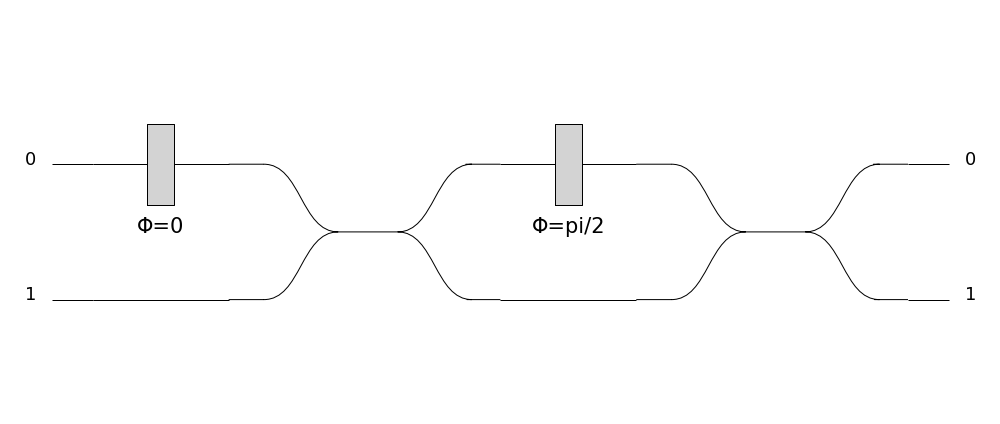

In [4]:
# Create the qpu
qpu = QPU_MZI()
# Display the interferometer
qpu.chip.pdisplay(output_format="mplot")

# BasicState

mzi_BasicState computes the output state distribution of any input Forck state in the photon number basis

In [5]:
def mzi_BasicState(input_state):
    """
    :param input_state: '|1,1>'
    :return: plots the output states probability as a function of the internal phase of the MZI
    """
    
    qpu = QPU_MZI()
    
    scan_range = np.arange(0, np.pi, 0.1)

    outcome_theta = {}
    outcome = []

    for theta in scan_range:

        output_prob = dict()

        qpu.phase_shifters[1].set_value(theta)
        sim = qpu.simulator_backend(qpu.chip.U)

        for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_state)):

            output_state = str(output_state)

            if output_state not in outcome:
                outcome.append(output_state)

            if output_state in output_prob:
                output_prob[output_state] += probability
            else:
                output_prob[output_state] = probability

        outcome_theta[theta] = output_prob

    fig, ax = plt.subplots()
    for measured_state in outcome:
        ax.plot(outcome_theta.keys(),
                 [outcome_theta[angle][measured_state] for angle in outcome_theta.keys()],
                 '-s',
                 label=measured_state,
                 alpha=0.9)
    ax.set_ylabel('Probability', fontsize=24)
    ax.set_xlabel('Internal phase of the MZI [rad]', fontsize=24)
    ax.legend(fontsize=18)
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=16)

    return 

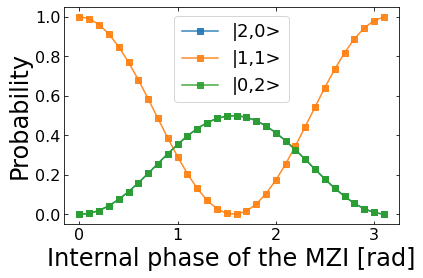

In [6]:
# Computes all the output states probabilities for a given input ket
mzi_BasicState('|1,1>')

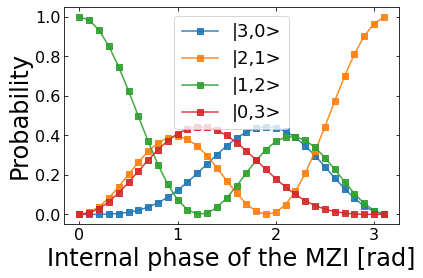

In [7]:
# Computes all the output states probabilities for a given input ket
mzi_BasicState('|2,1>')

# AnySource

mzi_Anysource computes the output state distribution of any input Forck state with click detectors

In [8]:
# From output state to outcome
def outputstate_to_2outcome(output):
    state = []
    for m in output:
        if m.isdigit():
            state.append(m)

    if int(state[0]) == 0 and int(state[1]) == 0:
        return None
    if int(state[0]) == 0 and int(state[1]) > 0:
        return '|0,1>'
    if int(state[0]) > 0 and int(state[1]) == 0:
        return '|1,0>'
    if int(state[0]) > 0 and int(state[1]) > 0:
        return '|1,1>'

In [16]:
def mzi_AnySource(input_states_dict):
    
    """
    :param input_states_dict: {'|1,1>':1}
    :return: visibility of the 2-photon interference fringe
    :plot: probability of each outcome as a function of the internal phase of the MZI
    """
    
    qpu = QPU_MZI()


    scan_range = np.arange(0, np.pi, 0.1)

    plot_outcome = {'|1,0>':[], '|1,1>':[], '|0,1>':[]}
    

    for theta in scan_range:

        outcome = {'|1,0>': 0,
                   '|1,1>': 0,
                   '|0,1>': 0
                  }

        qpu.phase_shifters[1].set_value(theta)
        
        sim = qpu.simulator_backend(qpu.chip.U)

        for input_n in input_states_dict:
            for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_n)):
                result = outputstate_to_2outcome(str(output_state))
                outcome[result] += input_states_dict[input_n] * probability

        plot_outcome['|1,0>'].append(outcome['|1,0>'])
        plot_outcome['|1,1>'].append(outcome['|1,1>'])
        plot_outcome['|0,1>'].append(outcome['|0,1>'])

    plt.figure()
    for out in plot_outcome:
        plt.plot(scan_range, plot_outcome[out], '-o', label=out)
    plt.xlabel('Phase [rad]', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.grid()
    plt.legend()

    # Compute the output distribution for phi2 = np.pi/2

    outcome = {'|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
              }

    qpu.phase_shifters[1].set_value(np.pi / 2)
    sim = qpu.simulator_backend(qpu.chip.U)

    for input_n in input_states_dict:

        for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_n)):
            result = outputstate_to_2outcome(str(output_state))
            outcome[result] += input_states_dict[input_n] * probability

    p_corr = outcome['|1,1>']

    # Compute the output distribution for phi2 = 0

    outcome = {'|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
              }

    qpu.phase_shifters[1].set_value(0)
    sim = qpu.simulator_backend(qpu.chip.U)

    for input_n in input_states_dict:

        for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_n)):
            result = outputstate_to_2outcome(str(output_state))
            outcome[result] += input_states_dict[input_n] * probability

    p_uncorr = outcome['|1,1>']

    return 1-2*p_corr/p_uncorr


1.0

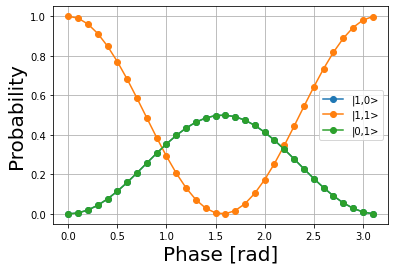

In [17]:
# Computes all visibility of the 2-photon fringe interference for a given dict of weighted input states
mzi_AnySource({'|1,1>':1})

# ImperfectSource
Here we suppose that we only have access to click detectors. All the outputs of the chip will be either a single click on one of the detector or a double click. We compute the probability of each of these outcomes.

In [18]:
def mzi_ImperfectSource_qpu(beta, g2, M, plotit=False):
    """
    output -> what come out of the chip (|2,2>, |2,1>, |3,1>, ...)
    outcome -> what we can measure with our SNSPD detectors
    :param beta: source brightness
    :param g2: 1-single-photon purity
    :param M: Indistinguishability
    :return: plot and visibility of the HOM
    """

    qpu = QPU_MZI()

    # Find out all the unput states that must be considered depending on the characteristics of the source
    source = pcvl.Source(brightness=beta,
                         multiphoton_component=g2,
                         indistinguishability=M,
                         multiphoton_model="distinguishable",
                         indistinguishability_model="homv")  # "homv", or "linear"
    # indistinguishability_model:
    # `homv` defines indistinguishability as HOM visibility,
    # `linear` defines indistinguishability as ratio of indistinguishable photons


    if plotit:
        # Scan phi2 over the range scan_range to show the HOM dip.
        scan_range = np.arange(0, np.pi, 0.1)
        to_plot = [[], [], []]
        label = ['|1,0>', '|1,1>', '|0,1>']

        for theta in scan_range:

            # All outcome are initialize to 0 probability
            outcome = {'|1,0>': 0,
                       '|1,1>': 0,
                       '|0,1>': 0
                       }

            qpu.phase_shifters[1].set_value(theta)

            p = pcvl.Processor({0: source,
                                  1: source,
                                  },
                                 qpu.chip)

            all_p, sv_out = p.run(qpu.simulator_backend)

            for output_state in sv_out:
                # Each output is mapped to an outcome
                result = outputstate_to_2outcome(str(output_state))
                # The probability of an outcome is added, weighted by the probability of this input
                if result:
                    outcome[result] +=  sv_out[output_state]

            to_plot[0].append(outcome['|1,0>'])
            to_plot[1].append(outcome['|1,1>'])
            to_plot[2].append(outcome['|0,1>'])

        plt.figure()
        for idx2, out in enumerate(to_plot):
            plt.plot(scan_range, out, '-o', label=label[idx2])
        plt.xlabel('Phase [rad]', fontsize=20)
        plt.ylabel('Probability', fontsize=20)
        plt.grid()
        plt.legend()

    # Compute the outcome distribution specifically for ph2=pi/2
    outcome = {'|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
               }
    qpu.phase_shifters[1].set_value(np.pi / 2)
    p = pcvl.Processor({0: source,
                        1: source,
                        },
                       qpu.chip)

    all_p, sv_out = p.run(qpu.simulator_backend)

    for output_state in sv_out:
        # Each output is mapped to an outcome
        result = outputstate_to_2outcome(str(output_state))
        # The probability of an outcome is added, weighted by the probability of this input
        if result:
            outcome[result] += sv_out[output_state]

    p_corr = outcome['|1,1>']

    # Compute the outcome distribution specifically for ph2=0
    outcome = {'|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
               }

    qpu.phase_shifters[1].set_value(0)
    p = pcvl.Processor({0: source,
                        1: source,
                        },
                       qpu.chip)
    all_p, sv_out = p.run(qpu.simulator_backend)

    for output_state in sv_out:
        # Each output is mapped to an outcome
        result = outputstate_to_2outcome(str(output_state))
        # The probability of an outcome is added, weighted by the probability of this input
        if result:
            outcome[result] += sv_out[output_state]

    p_uncorr = outcome['|1,1>']

    return 1-2*p_corr/p_uncorr

0.8502947296840426

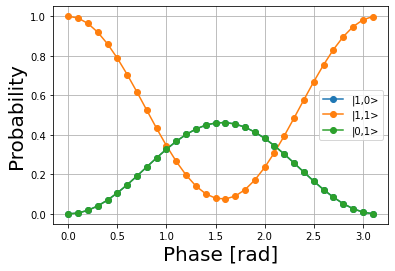

In [19]:
# Computes all visibility of the 2-photon fringe interference for an imperfect single-photon source
mzi_ImperfectSource_qpu(beta=1, g2=0.05 ,M=0.9, plotit=True)